In [ ]:
# Include Necessary Modules
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

In [ ]:
model =torch.load('model.pt')

In [ ]:
class ARMBench(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        #  List: get cat id from coco
        cat_ids = coco.getCatIds()
        # print(cat_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))
        # create mask
        mask = np.stack([np.where(coco.annToMask(ann)>0,1,0) for ann in coco_annotation])
        # number of objects in the image
        num_objs = len(coco_annotation)
        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        areas = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(coco_annotation[i]['category_id'])
            areas.append(coco_annotation[i]['area'])

        # Reshape Mask and convert to uint8 type
        masks = mask.transpose((1,2,0))
        # Tensorize Bbox
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I have two classes: Tote class and Object class)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        # Apply transforms
        if self.transforms is not None:
            img = self.transforms(img)
            masks = self.transforms(masks)

        my_annotation["masks"] = masks

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [ ]:
# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [ ]:
def get_prediction(img_path, model, threshold=0.5, url=False):

  INSTANCE_CATEGORY_NAMES = ["Tote","Object"]
  img = Image.open(img_path) # This is for local images
  transform = get_transform()
  img = transform(img)
  img = img.cuda() # Only if GPU, otherwise comment this line
  pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
  #Let's change it to GPU
  # pred = pred.cpu() # We will just send predictions back to CPU
  # Now we need to extract the bounding boxes and masks
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] >0.5).squeeze().detach().cpu().numpy()
  pred_class = [INSTANCE_CATEGORY_NAMES[i-1] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [ ]:
def instance_segmentation(img_path, model, threshold=0.9, rect_th=3,
                          text_size=3, text_th=3, url=False):
  # Make predictions using the image input the threshlod
  masks, boxes, pred_cls = get_prediction(img_path, model, threshold=threshold, url=url)
  # Load the image from the path
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
  # Add bounding box and instance colors on the image
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.8, 0)
    pt1 = tuple(int(x) for x in boxes[i][0])
    pt2 = tuple(int(x) for x in boxes[i][1])
    cv2.rectangle(img, pt1, pt2, color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img, pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  return img, pred_cls, masks[i]

In [ ]:
# This function helps in adding random colors as instance masks
def random_color_masks(image):
  # I will copy a list of colors here
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

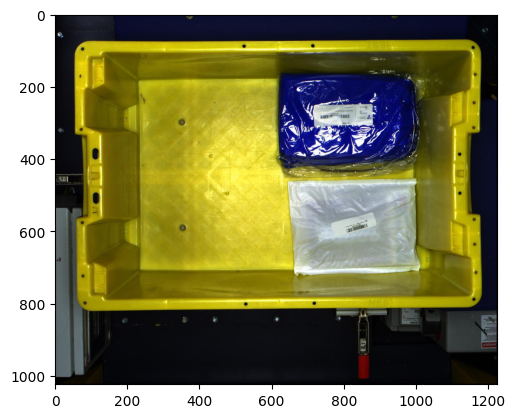

In [ ]:
input_img = Image.open("test.jpg")
plt.imshow(input_img)

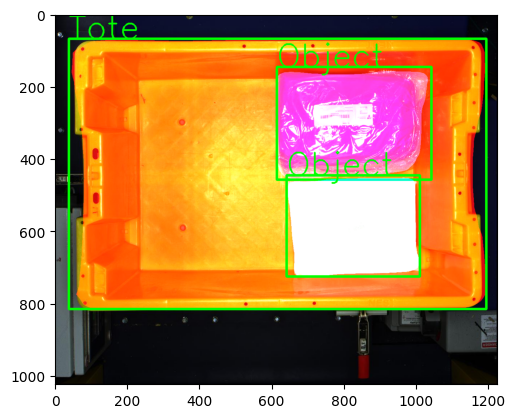

In [ ]:
# Change model to testing mode
model.eval()
# Here use your path of a custom image instead of test.jpg
img, pred_classes, masks = instance_segmentation('test.jpg', model, rect_th=5, text_th=4)
plt.imshow(img)

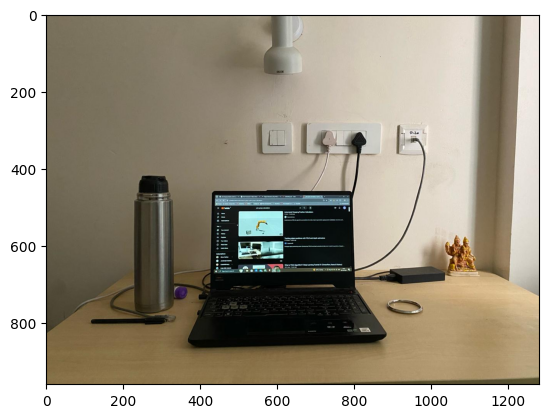

In [ ]:
input_img = Image.open("test2.jpeg")
plt.imshow(input_img)

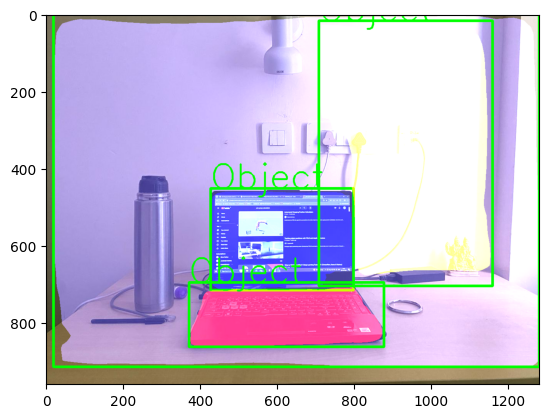

In [ ]:
# Change model to testing mode
model.eval()
# Here use your path of a custom image instead of test.jpg
img, pred_classes, masks = instance_segmentation('test2.jpeg', model, rect_th=5, text_th=4)
plt.imshow(img)

In [ ]:
# path to your own data and coco file
train_data_dir = './content/armbench-segmentation-0.1/mix-object-tote/images'
train_armbench = './content/armbench-segmentation-0.1/mix-object-tote/train.json'
test_armbench = './content/armbench-segmentation-0.1/mix-object-tote/test.json'

# create own Dataset
train_dataset = ARMBench(root=train_data_dir,
                          annotation=train_armbench,
                          transforms=get_transform())

test_dataset = ARMBench(root=train_data_dir,
                          annotation=test_armbench,
                          transforms=get_transform())

# Sample 10,000 random indices from the original dataset
random_indices = random.sample(range(len(train_dataset)),100)

# Create a subset of the original dataset using the sampled indices
train_subset = torch.utils.data.Subset(train_dataset, random_indices)



# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 1
test_batch_size = 1

# train and test DataLoader
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=test_batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=17.40s)
creating index...
index created!
loading annotations into memory...
Done (t=3.29s)
creating index...
index created!


In [ ]:
from tqdm.notebook import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
# Set the model to evaluation mode
model.eval()
# Define the device (CPU or GPU) to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
# Create a COCO instance of Dataset for evaluation
coco_gt = COCO(test_armbench)  # Replace 'path/to/annotations.json' with the path to your COCO annotations file

# Define the list to store COCO-style results
coco_results = []

# Iterate over the test dataset and evaluate the model
for images, targets in tqdm(test_dataloader):
    torch.cuda.empty_cache()
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # Forward pass
    outputs = model(images)

    # Post-processing: Get the predicted bounding boxes, labels, and scores
    pred_boxes = outputs[0]['boxes'].cpu().detach()
    pred_labels = outputs[0]['labels'].cpu().detach()
    pred_scores = outputs[0]['scores'].cpu().detach()

    # Convert the predicted boxes, labels, and scores to COCO format
    image_id = targets[0]['image_id'].item()
    coco_results.extend([
        {'image_id': image_id, 'category_id': pred_labels[i].item(), 'bbox': pred_boxes[i].tolist(), 'score': pred_scores[i].item()}
        for i in range(len(pred_boxes))
    ])

# Load the results into COCO evaluation API
coco_dt = coco_gt.loadRes(coco_results)

# Run the COCO evaluation
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Get the mAP score
mAP = coco_eval.stats[0]

# Print the mAP score
print(f"mAP: {mAP}")


loading annotations into memory...
Done (t=1.48s)
creating index...
index created!


  0%|          | 0/6605 [00:00<?, ?it/s]

Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=43.18s).
Accumulating evaluation results...
DONE (t=1.94s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

In [ ]:
coco_gt

In [ ]:
# DEMO images loading


d:\majorproject\armbenchSegmentation\armbench-segmentation-0.1.tar


# Selecting the Middle Object

In [ ]:
import numpy as np

def instance_segmentation_middle_object(img_path, model, threshold=0.9, rect_th=3, text_size=3, text_th=3, url=False):
    masks, boxes, pred_cls = get_prediction(img_path, model, threshold=threshold, url=url)

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get the center coordinates of the image
    img_height, img_width = img.shape[:2]
    center_x, center_y = img_width // 2, img_height // 2

    # Find the object closest to the center, excluding the 'tote' class
    min_distance = float('inf')
    closest_obj_idx = None
    for i in range(len(masks)):
        if pred_cls[i] == 'Tote':
            continue

        x1, y1 = boxes[i][0]
        x2, y2 = boxes[i][1]
        obj_center_x = (x1 + x2) // 2
        obj_center_y = (y1 + y2) // 2
        distance = np.sqrt((obj_center_x - center_x) ** 2 + (obj_center_y - center_y) ** 2)
        if distance < min_distance:
            min_distance = distance
            closest_obj_idx = i

    # Draw the closest object
    if closest_obj_idx is not None:
        rgb_mask = random_color_masks(masks[closest_obj_idx])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.8, 0)
        pt1 = tuple(int(x) for x in boxes[closest_obj_idx][0])
        pt2 = tuple(int(x) for x in boxes[closest_obj_idx][1])
        cv2.rectangle(img, pt1, pt2, color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img, pred_cls[closest_obj_idx], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)

    return img, pred_cls, masks[closest_obj_idx] if closest_obj_idx is not None else None

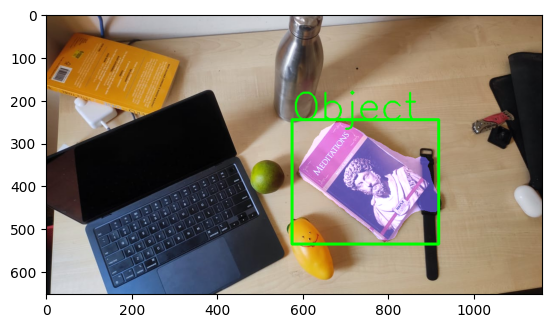

In [ ]:
# Change model to testing mode
model.eval()
# Here use your path of a custom image instead of test.jpg
img, pred_classes, masks = instance_segmentation_middle_object('demoimages/1.jpeg', model, rect_th=5, text_th=4)
plt.imshow(img)

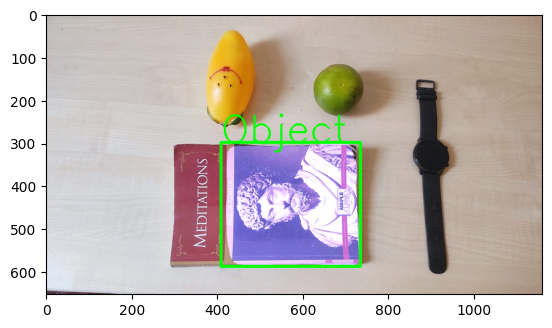

In [ ]:
# Change model to testing mode
model.eval()
# Here use your path of a custom image instead of test.jpg
img, pred_classes, masks = instance_segmentation_middle_object('demoimages/2.jpeg', model, rect_th=5, text_th=4)
plt.imshow(img)

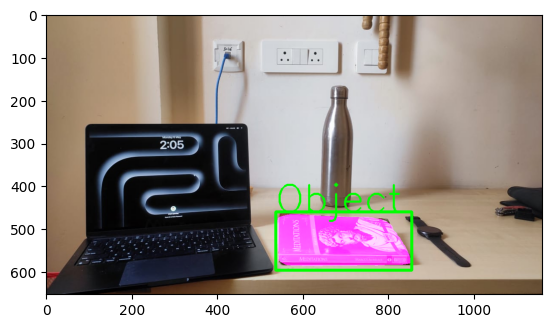

In [ ]:
# Change model to testing mode
model.eval()
# Here use your path of a custom image instead of test.jpg
img, pred_classes, masks = instance_segmentation_middle_object('demoimages/3.jpeg', model, rect_th=5, text_th=4)
plt.imshow(img)

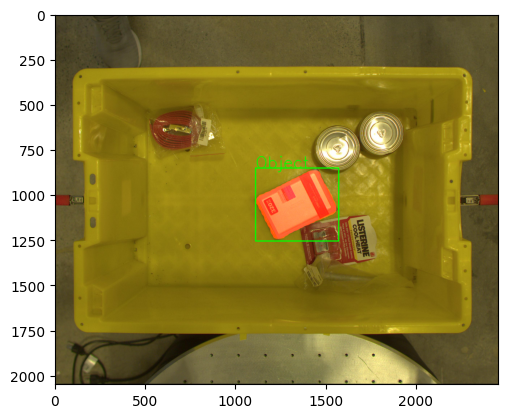

In [ ]:
# Change model to testing mode
model.eval()
# Here use your path of a custom image instead of test.jpg
img, pred_classes, masks = instance_segmentation_middle_object('totedemoimages/tote1.jpg', model, rect_th=5, text_th=4)
plt.imshow(img)

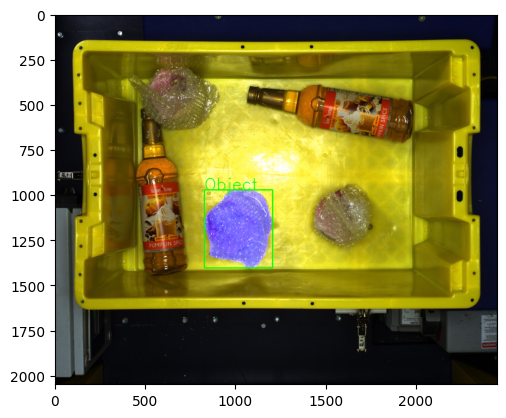

In [ ]:
# Change model to testing mode
model.eval()
# Here use your path of a custom image instead of test.jpg
img, pred_classes, masks = instance_segmentation_middle_object('totedemoimages/tote2.jpg', model, rect_th=5, text_th=4)
plt.imshow(img)

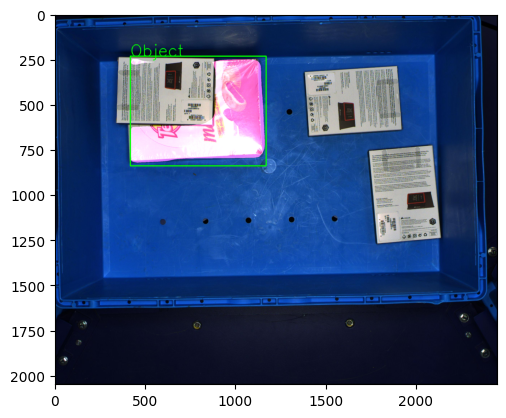

In [ ]:
# Change model to testing mode
model.eval()
# Here use your path of a custom image instead of test.jpg
img, pred_classes, masks = instance_segmentation_middle_object('totedemoimages/tote3.jpg', model, rect_th=5, text_th=4)
plt.imshow(img)

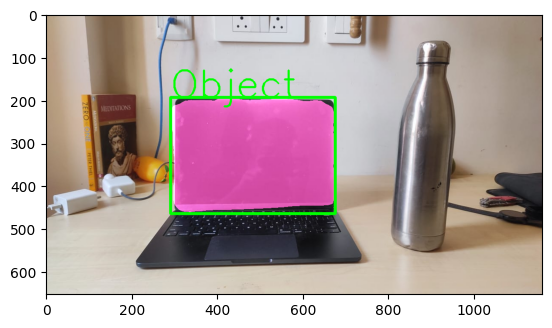

In [ ]:
# Change model to testing mode
model.eval()
# Here use your path of a custom image instead of test.jpg
img, pred_classes, masks = instance_segmentation_middle_object('demoimages/9.jpeg', model, rect_th=5, text_th=4)
plt.imshow(img)

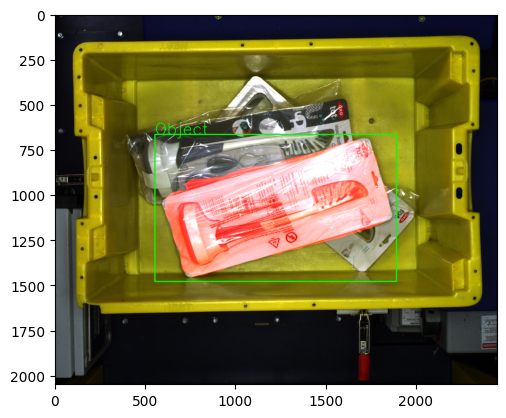

In [ ]:
# Change model to testing mode
model.eval()
# Here use your path of a custom image instead of test.jpg
img, pred_classes, masks = instance_segmentation_middle_object('totedemoimages/tote4.jpg', model, rect_th=5, text_th=4)
plt.imshow(img)